In [3]:
!nvidia-smi

Fri Jun 30 03:35:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0B:00.0 Off |                    0 |
| N/A   30C    P0    43W / 163W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infer

# Infer single patinets

In [38]:
workspace_dir = '/nfs/Workspace/CardiacSeg'

import os
import sys
from pathlib import PurePath
sys.path.append(workspace_dir)

import pandas as pd

from monai.transforms import (
   Compose,
   AddChanneld,
   EnsureChannelFirstd,
   LoadImaged,
   Orientationd,
   SqueezeDimd,
   LoadImage,
   LabelFilterd,
   MapLabelValued
)
from datasets.mmwhs_dataset import get_data_dicts, get_inf_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred, show_img_lbl_preds, show_img_lbl_preds_overlap

from expers.infer_utils import get_tune_model_dir, get_data_path, get_pred_path

model_name = 'unet3d' #'swinunetr'
data_name = 'mmwhs'
exp_name = 'exp_2_tn2'
data_dict_file_name = 'exp_2.json'

root_exp_dir = os.path.join(
    workspace_dir, 
    'exps',
    'exps',
    model_name,
    data_name,
    'tune_results'
)

root_data_dir = os.path.join(
    workspace_dir, 
    'dataset',
    data_name
)

data_dir = os.path.join(root_data_dir, 'ct_train') # 'ct_test'


model_dir = get_tune_model_dir(root_exp_dir, exp_name)

best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')

infer_dir = os.path.join(
    workspace_dir, 
    'exps',
    'exps',
    model_name,
    data_name,
    'infers',
    exp_name,
)

print('\nbest model:',best_checkpoint)
print('infer dir:',infer_dir)

# 2023 2037
pid = 'ct_train_1016_image' #'ct_test_2037_image'
data_dict = get_data_path(data_dir, data_name, pid)
data_dict['pred'] = get_pred_path(root_exp_dir, exp_name, data_dict['image'])

img_pth = data_dict['image']
lbl_pth = data_dict['label'] 
print(img_pth)
print(lbl_pth)
print(data_dict['pred'])

%cd /nfs/Workspace/CardiacSeg/exps/exps/{model_name}/{data_name}

Loading results from /nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/tune_results/exp_2_tn2...

Best trial 3dfb3_00000: 
config: {'exp': {'exp': 'exp_2_tn2'}}
tt_dice: 0
tt_hd95: 0
esc: 20
best log dir: /nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/tune_results/exp_2_tn2/main_3dfb3_00000_0_exp=exp_exp_2_tn2_2023-06-05_02-04-02

best model: /nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/tune_results/exp_2_tn2/main_3dfb3_00000_0_exp=exp_exp_2_tn2_2023-06-05_02-04-02/models/best_model.pth
infer dir: /nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/infers/exp_2_tn2
/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_image.nii.gz
/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_label.nii.gz
/nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/tune_results/infers/exp_2_tn2/ct_train_1016_image.nii.gz
/nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs


Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.


In [39]:
!/opt/conda/bin/python /nfs/Workspace/CardiacSeg/expers/infer.py \
--model_name={model_name} \
--data_name={data_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--img_pth={img_pth} \
--out_channels=8 \
--patch_size=4 \
--feature_size=48 \
--drop_rate=0.1 \
--depths 3 3 9 3 \
--kernel_size 7 \
--exp_rate 4 \
--norm_name='layer' \
--a_min=-70 \
--a_max=677 \
--space_x=1.0 \
--space_y=1.0 \
--space_z=1.0 \
--roi_x=96 \
--roi_y=96 \
--roi_z=96 \
--infer_post_process \
--lbl_pth={lbl_pth} \
# --infer_overlap=0.5 \

cuda is available
model: unet3d
=> loaded checkpoint '/nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/tune_results/exp_2_tn2/main_3dfb3_00000_0_exp=exp_exp_2_tn2_2023-06-05_02-04-02/models/best_model.pth')
infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_image.nii.gz', 'label': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_label.nii.gz'}
monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since ver

In [5]:
# from data_utils.io import load_json, save_json
# inf_json = '/nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/inf_1.json'
# ds = get_inf_data_dicts(data_dir)
# save_json(ds, inf_json)

save json to /nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/inf_1.json


In [13]:
!pwd

/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_a1/mmwhs


In [12]:
# !zip -r exp_1_tn2.zip '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_a1/mmwhs/infers/exp_1_tn2/' 

In [10]:
# !zip -r exp_3_r128_128_96.zip '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_a1/mmwhs/infers/exp_3_r128_128_96/' 

In [8]:
!/opt/conda/bin/python /nfs/Workspace/CardiacSeg/expers/infer.py \
--model_name={model_name} \
--data_name={data_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--data_dicts_json={inf_json} \
--out_channels=8 \
--patch_size=4 \
--feature_size=48 \
--drop_rate=0.1 \
--depths 3 3 9 3 \
--kernel_size 7 \
--exp_rate 4 \
--norm_name='layer' \
--a_min=-70 \
--a_max=677 \
--space_x=1.0 \
--space_y=1.0 \
--space_z=1.0 \
--roi_x=96 \
--roi_y=96 \
--roi_z=96 \
--infer_post_process

cuda is available
model: unetcnx_a1
patch size: 4
ker size: 7
exp rate: 4
feature sizes: [48, 96, 192, 384]
depths: [3, 3, 9, 3]
drop rate: 0.1
use init weights: False
is conv stem: False
Tag 'ds (deeply supervised)' found in state dict - fixing!
=> loaded checkpoint '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_a1/mmwhs/tune_results/exp_1_tn2/main_f11c7_00000_0_optim=lr_0_0007_weight_decay_0_0005_2023-05-18_05-15-02/models/best_model.pth')
load json from /nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/inf_1.json
infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_test/ct_test_2001_image.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
infer time: 3.4304444789886475 sec
use post process infer
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor 

In [35]:
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06'

# img_pth='/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz'
# lbl_pth='/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz'
# pred_pth='/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_unetcnx.nii.gz'

print(data_dir)

/nfs/Workspace/CardiacSeg/dataset/chgh/block_06


In [36]:
# training
!PYTHONPATH=/nfs/Workspace/CardiacSeg /opt/conda/bin/python /nfs/Workspace/CardiacSeg/expers/eval_label.py \
--out_channels=2 \
--a_min=-42 \
--a_max=423 \
--space_x=1.0 \
--space_y=1.0 \
--space_z=1.0 \
--data_dir={data_dir}
# --img_pth={img_pth} \
# --lbl_pth={lbl_pth} \
# --pred_pth={pred_pth} \

cuda is available
/nfs/Workspace/CardiacSeg/dataset/chgh/block_06
infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz', 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz', 'pred': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_pwsb.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
pred name: pwsb
dice: 0.813605
hd95: 9.1104335791443

infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz', 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz', 'pred': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_t.nii.gz'}
pred name: t
dice: 0.776614
hd95: 17.291616465790582

infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz', 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/blo

# Summarize exp results

## summartize data dict and dice, save out dir

In [42]:
import os
from pprint import pprint
import shutil

from expers.infer_utils import get_data_path, get_pred_path, get_tune_dir, get_eval_csv_path, get_eval_val


pid = 'ct_train_1016_image'
root_dir = '/nfs/Workspace/CardiacSeg/exps/exps'

%cd {root_dir}

exp_name = 'exp_2_tn2'
model_names = ['unet3d', 'attention_unet', 'cotr', 'unetr', 'swinunetr', 'unetcnx_a1']
exp_names = [exp_name for _ in model_names] 
root_exp_dirs = [os.path.join(root_dir, m, 'mmwhs') for m in model_names]

is_save_output = True
out_dir = './output'
out_infer_dir = os.path.join(out_dir, 'infers')
out_eval_dir = os.path.join(out_dir, 'evals')
os.makedirs(os.path.join(out_infer_dir), exist_ok=True)
os.makedirs(os.path.join(out_eval_dir), exist_ok=True)


data_dict = get_data_path(data_dir, data_name, pid)
dice_dict = {}
for exp_name, model_name, root_exp_dir in zip(exp_names, model_names, root_exp_dirs):
    key = f'{model_name}'
    
    # add pred path to data dict
    data_dict[key] = get_pred_path(root_exp_dir, exp_name, data_dict['image'])

    # read dice by pid
    tune_dir = get_tune_dir(os.path.join(root_exp_dir, 'tune_results', exp_name))
    csv_pth = get_eval_csv_path(tune_dir)
    dice_dict[key] = get_eval_val(csv_pth, pid)
    
    if is_save_output:
        # copy pred file
        shutil.copyfile(data_dict[key], os.path.join(out_infer_dir, f'{model_name}_{pid}.nii.gz'))

        # copy csv file
        shutil.copyfile(csv_pth, os.path.join(out_eval_dir, f'{model_name}_best_model.csv'))


pprint(data_dict)
pprint(dice_dict)

/nfs/Workspace/CardiacSeg/exps/exps
{'attention_unet': '/nfs/Workspace/CardiacSeg/exps/exps/attention_unet/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz',
 'cotr': '/nfs/Workspace/CardiacSeg/exps/exps/cotr/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz',
 'image': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_image.nii.gz',
 'label': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_label.nii.gz',
 'swinunetr': '/nfs/Workspace/CardiacSeg/exps/exps/swinunetr/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz',
 'unet3d': '/nfs/Workspace/CardiacSeg/exps/exps/unet3d/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz',
 'unetcnx_a1': '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_a1/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz',
 'unetr': '/nfs/Workspace/CardiacSeg/exps/exps/unetr/mmwhs/infers/exp_2_tn2/ct_train_1016_image.nii.gz'}
{'attention_unet': {'dice': 0.6825443171428572, 'hd95': 80.48683435714285},
 'cotr': {'dice': 0.8976974285714284, 'hd95'

Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.


## load out dir

In [43]:
import os
from pprint import pprint
import shutil

from expers.infer_utils import get_data_path, get_pred_path, get_tune_dir, get_eval_csv_path, get_eval_val

out_dir = './output'
out_infer_dir = os.path.join(out_dir, 'infers')
out_eval_dir = os.path.join(out_dir, 'evals')

data_dict = get_data_path(data_dir, data_name, pid)
dice_dict = {}
model_names = ['unet3d', 'attention_unet', 'cotr', 'unetr', 'swinunetr', 'unetcnx_a1']
for model_name in model_names:
    pred_path = os.path.join(out_infer_dir, f'{model_name}_{pid}.nii.gz')
    data_dict[model_name] = pred_path
    
    csv_pth = os.path.join(out_eval_dir, f'{model_name}_best_model.csv')
    dice_dict[model_name] = get_eval_val(csv_pth, pid)['dice']

pprint(data_dict)
pprint(dice_dict)

{'attention_unet': './output/infers/attention_unet_ct_train_1016_image.nii.gz',
 'cotr': './output/infers/cotr_ct_train_1016_image.nii.gz',
 'image': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_image.nii.gz',
 'label': '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1016_label.nii.gz',
 'swinunetr': './output/infers/swinunetr_ct_train_1016_image.nii.gz',
 'unet3d': './output/infers/unet3d_ct_train_1016_image.nii.gz',
 'unetcnx_a1': './output/infers/unetcnx_a1_ct_train_1016_image.nii.gz',
 'unetr': './output/infers/unetr_ct_train_1016_image.nii.gz'}
{'attention_unet': 0.6825443171428572,
 'cotr': 0.8976974285714284,
 'swinunetr': 0.9259005314285714,
 'unet3d': 0.7624745214285714,
 'unetcnx_a1': 0.9260646057142857,
 'unetr': 0.8759493657142857}


# Show exp results

In [35]:
keys = list(data_dict.keys())

loader = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    Orientationd(keys=keys, axcodes='PLI'),
    SqueezeDimd(keys=keys)
])

data = loader(data_dict)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


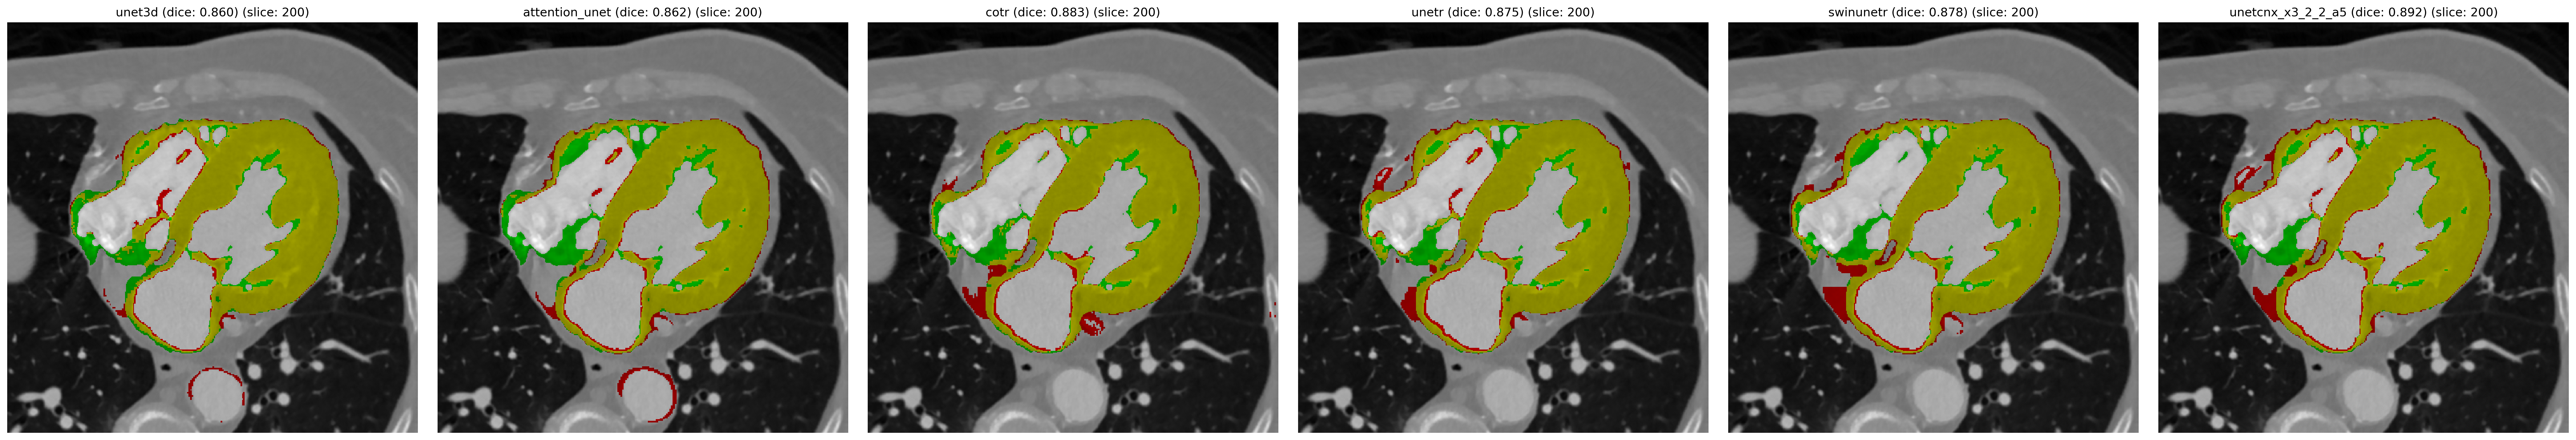

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.facecolor"] = 'none'

from expers.infer_utils import get_img_lbl_preds

num_classes = 2
slice_idxs = [200] #[100,150,200,250]
alpha = 0.5
axis_off = True
#num_img = len(data_dict)
#fig_size = (num_img*5, num_img*len(slice_idxs))
num_img = len(data_dict) - 2 
fig_size = (num_img*6, len(slice_idxs)*6)
show_img = False
show_lbl_dc = True

keys = dice_dict.keys()

pred_titles = [f'{key} (dice: {dice_dict[key]:.3f})'for key in keys]

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='a')

# show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

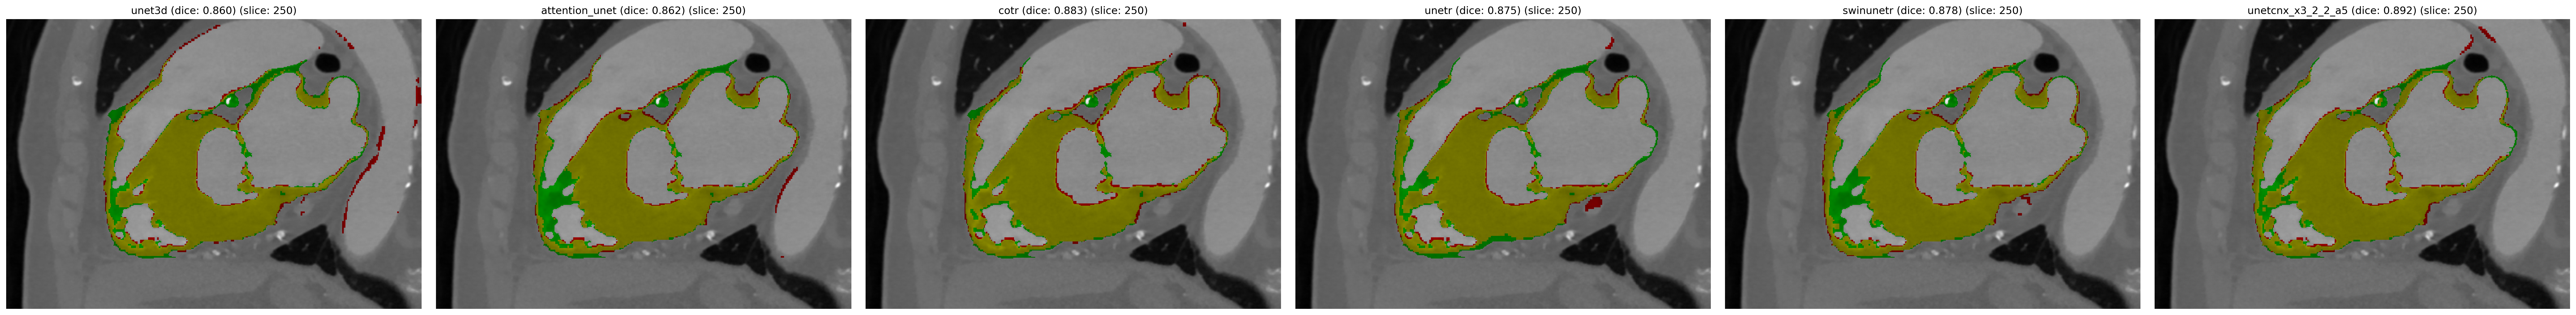

In [10]:
slice_idxs = [250] #[150,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='s', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

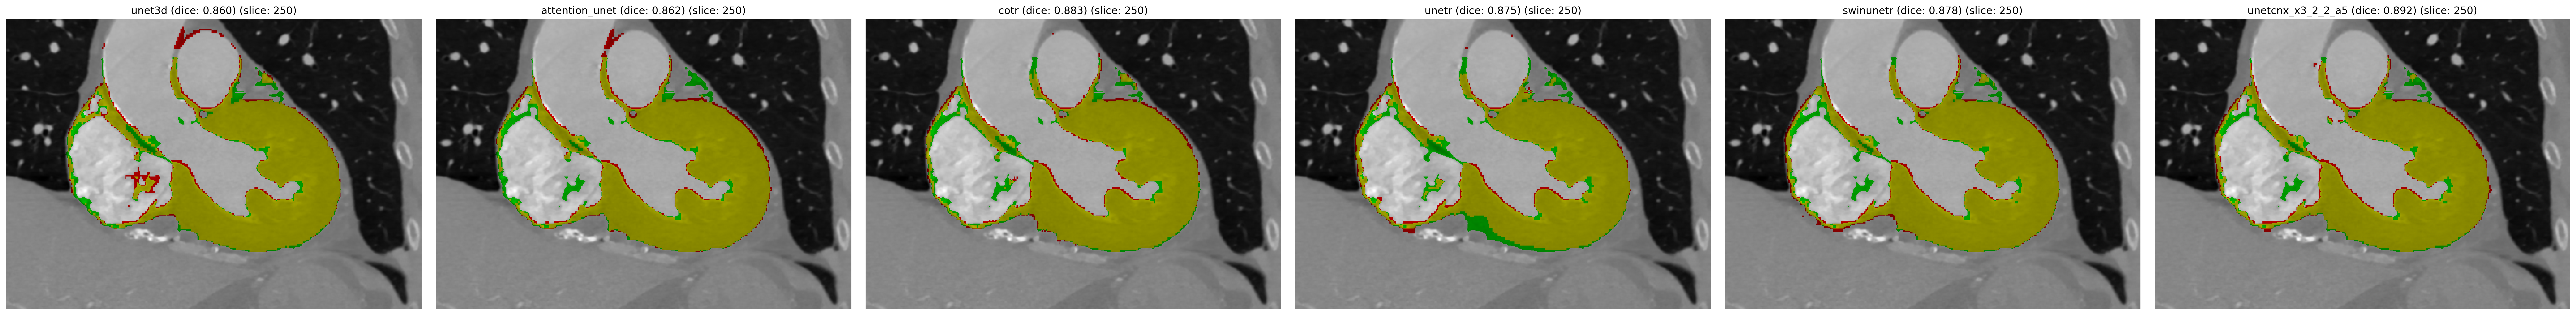

In [11]:
slice_idxs = [250] # [200,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='c', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc,
)

In [44]:
keys = list(data_dict.keys())

loader = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    LabelFilterd(keys=keys[1:], applied_labels=[500, 600, 420, 550, 205, 820, 850]),
    MapLabelValued(keys=keys[1:], orig_labels=[0, 500, 600, 420, 550, 205, 820, 850],
                    target_labels=[0, 1, 2, 3, 4, 5, 6, 7]),

    Orientationd(keys=keys, axcodes='LPI'), #LPI
    SqueezeDimd(keys=keys)
])

data = loader(data_dict)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [45]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.facecolor"] = 'none'

from expers.infer_utils import get_img_lbl_preds

num_img = 6
slice_idxs = [256] # [200,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='s', is_trans=True)

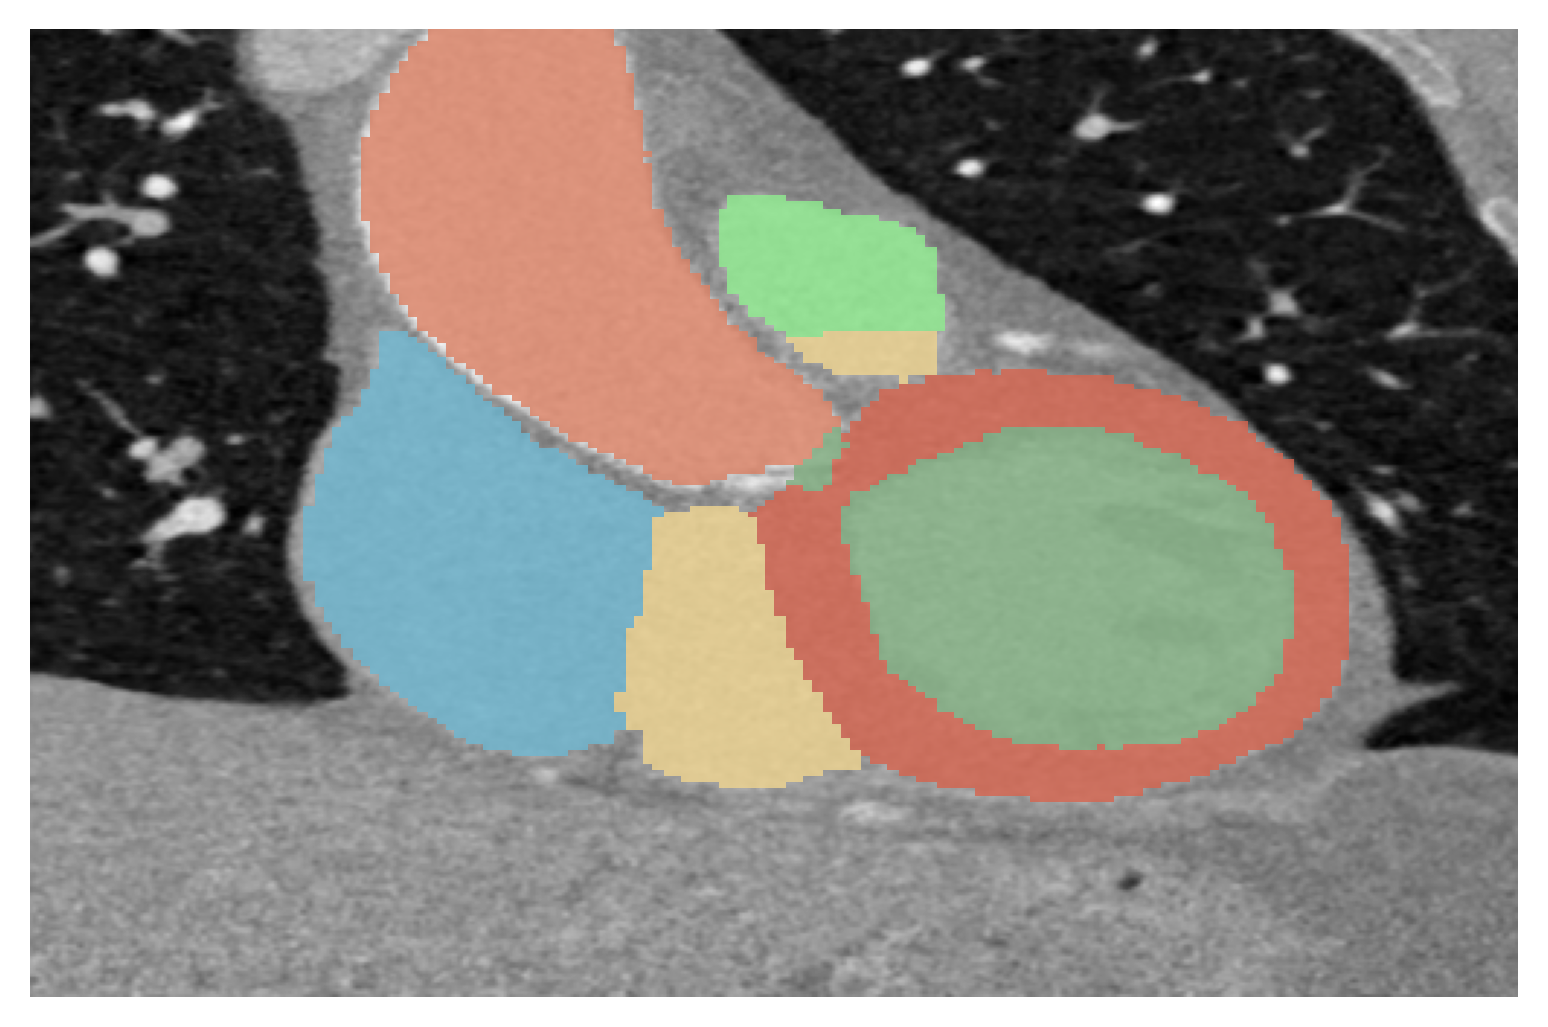

In [46]:
from data_utils.visualization import get_pred_label_overlap_img, get_slicer_cmap
import numpy as np

out_dir = './output'
pid = 'ct_train_1016_image'
alpha = 0.8
num_classes = 8

out_vis_dir = os.path.join(out_dir, 'vis')
os.makedirs(out_vis_dir, exist_ok=True)

img, lbl = imgs[0], lbls[0]
for pred, model_name in zip(preds[0][1:], keys[1:]):
    plt.imshow(img, cmap="gray")
    im_masked = np.ma.masked_where(pred == 0, pred)
    plt.imshow(
        im_masked,
        cmap=get_slicer_cmap(num_classes-1),
        interpolation='none',
        alpha=alpha,
        vmin=1,
        vmax=num_classes
    )
    plt.axis('off')
    plt.savefig(
        os.path.join(out_vis_dir, f'{model_name}_{pid}_c.png'),
        bbox_inches='tight',
        pad_inches=0
    )